In [25]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans

In [31]:
def make_full_dates(df, ts_colname, y_colname, first, last) -> pd.DataFrame:
    """Заменяет nan нулями"""
    dates = (
        pd.date_range(first, last, freq=pd.DateOffset(days=1))
        .to_frame()
        .rename(columns={0: ts_colname})
    )
    df = pd.concat([df, dates]).reset_index(drop=True)
    df = df.groupby(ts_colname)[y_colname].sum().reset_index()

    return df

    
def group_fill(df, ts_colname, key, col, how) -> pd.DataFrame:
    df = df.sort_values([ts_colname, key]).reset_index(drop=True)
    df[col] = df.groupby(key)[col].transform(lambda x: x.fillna(method=how))
    
    return df

# Task 1

В данных HW_6_data.csv есть сезонность в цене SKU (или группы SKU), которая изменяется в зависимости от:


Праздничных недель или недель со знаменательными событиями (например, 1 сентября).
Летних недель.
Предновогодних недель (конец ноября — декабрь).


Задача состоит в классификации предложенных SKU на классы присутствующих сезонностей (см. пункты выше), то есть на 3 класса (каждый SKU может быть отнесен максимум только к одному из них).

Запишите данные группы в файл part1.txt. 
Ответ на каждый пункт должен быть на новой строке, SKU записываются через запятую.

Один выходной файл: part1.txt

In [26]:
df_train = pd.read_csv('./data/HW_6_data.csv')
df_train['dates'] = pd.to_datetime(df_train['dates'])
df_train = df_train.sort_values(by='dates').reset_index(drop=True)
df_train.columns = ['ds', 'SKU', 'y']


print(df_train.shape)
df_train.head()

(3242, 3)


,ds,SKU,y
0,2018-02-11,29251,323.0
1,2018-02-13,29251,323.0
2,2018-02-14,29251,323.0
3,2018-02-15,29251,323.0
4,2018-02-16,29251,323.0


In [32]:
%%time


sku_from_train = set(df_train.SKU.unique())
df_full_dates = []
for sku in tqdm(sku_from_train):
    df_sku = df_train[df_train['SKU'] == sku][['ds', 'y']]
    
    first = df_sku['ds'].min()
    last = df_sku['ds'].max()
    
    df_sku = make_full_dates(df_sku, 'ds', 'y', first, last)
    
    # Заполним последним валидным значением
    df_sku.loc[df_sku['y'] == 0, 'y'] = np.nan
    df_sku['y'] = df_sku['y'].fillna(method='ffill')
    
    
    df_sku['SKU'] = sku
    df_full_dates.append(df_sku)
    
df_full_dates = pd.concat(df_full_dates)

100%|██████████| 10/10 [00:00<00:00, 67.13it/s]

CPU times: user 151 ms, sys: 3.85 ms, total: 155 ms
Wall time: 154 ms


In [47]:
df_full_dates_pivot = df_full_dates.pivot_table(columns='SKU', index='ds', values='y', aggfunc='sum')

### Выбираем "вручную"

<Figure size 1080x792 with 0 Axes>

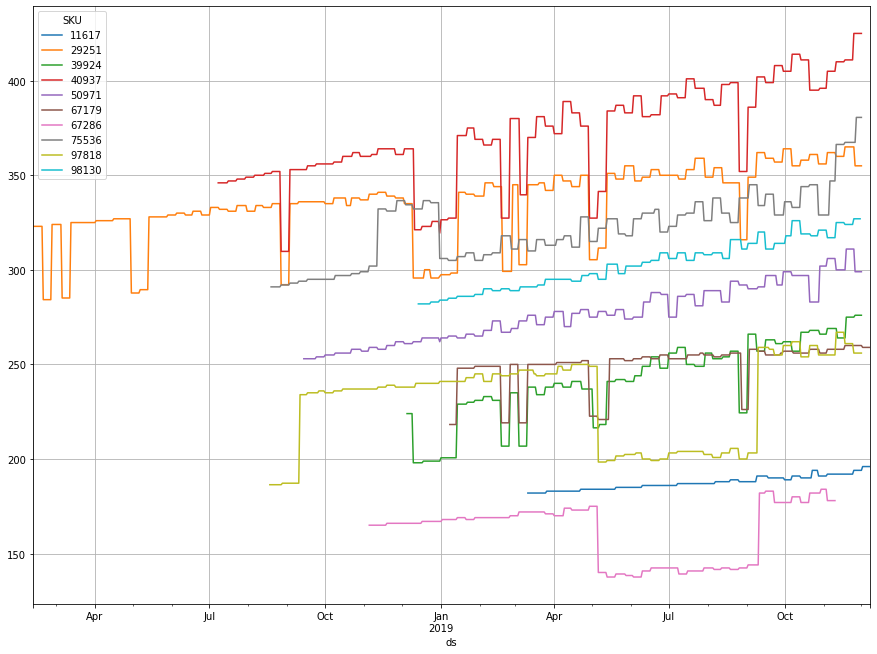

In [20]:
plt.figure()
df_full_dates_pivot.plot(figsize=(15, 11))
plt.grid()
plt.show()

In [121]:
first_cluster = [40937, 29251, 39924, 67179]
second_cluster = [97818, 67286]
third_cluster = [75536]

In [122]:
# with open('./solution/part1.txt', 'w') as f:
#     f.write(','.join(map(str,first_cluster)))
#     f.write('\n')
#     f.write(','.join(map(str,second_cluster)))
#     f.write('\n')
#     f.write(','.join(map(str,third_cluster)))

### Попробуем автоматически K-means


In [ ]:
scaler = StandardScaler()

In [54]:
df_clustering = df_full_dates.pivot_table(index='SKU', columns='ds', values='y', aggfunc='sum').fillna(0)

In [55]:
X_scaled = scaler.fit_transform(df_clustering.values)

In [61]:
ts_kmeans = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
ts_kmeans.fit(X_scaled)
df_clustering['cluster'] = ts_kmeans.predict(X_scaled)

/nfs/env/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 10 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [62]:
clusters = df_clustering.reset_index().groupby('cluster')['SKU'].unique().reset_index()

# Task 2

Тестовые данные находятся в файле HW_6_test.csv.

Сделайте предсказание диапазонов цен для SKU по датам: укажите нижнюю (lower_bound) и верхнюю (upper_bound) границы для цены.

Файл с результатами part2.csv должен содержать колонки 'SKU', 'dates', 'predicted_lower_bound', 'predicted_upper_bound'.

Пороговое значение intersection over union IoU>0.25.

Один выходной файл: part2.csv

In [5]:
df_train = pd.read_csv('./data/HW_6_data.csv')
df_train['dates'] = pd.to_datetime(df_train['dates'])
df_train = df_train.sort_values(by='dates').reset_index(drop=True)
df_train.columns = ['ds', 'SKU', 'y']


print(df_train.shape)
df_train.head()

(3242, 3)


,ds,SKU,y
0,2018-02-11,29251,323.0
1,2018-02-13,29251,323.0
2,2018-02-14,29251,323.0
3,2018-02-15,29251,323.0
4,2018-02-16,29251,323.0


In [6]:
df_test = pd.read_csv('./data/HW_6_testcsv.csv')
df_test['dates'] = pd.to_datetime(df_test['dates'])
df_test = df_test.sort_values(by='dates').reset_index(drop=True)
df_test.columns = ['SKU', 'ds']
sku_from_test = set(df_test.SKU.unique())


print(df_test.shape)
df_test.head()

(40, 2)


,SKU,ds
0,67286,2019-11-11
1,67286,2019-11-18
2,67286,2019-11-25
3,50971,2019-12-02
4,98130,2019-12-02


In [8]:
%%time

forecast = []
for sku in tqdm(sku_from_test):
    df_sku = df_train[df_train['SKU'] == sku][['ds', 'y']]
    
    first = df_sku['ds'].min()
    last = df_sku['ds'].max()
    
    df_sku = make_full_dates(df_sku, 'ds', 'y', first, last)
    
    # Заполним последним валидным значением
    df_sku.loc[df_sku['y'] == 0, 'y'] = np.nan
    df_sku['y'] = df_sku['y'].fillna(method='ffill')

    model = Prophet()
    model.fit(df_sku)
    
    future = model.make_future_dataframe(periods=365)
    cur_forecast = model.predict(future)[['ds', 'yhat_lower',  'yhat_upper']]
    cur_forecast['SKU'] = sku
    forecast.append(cur_forecast)
    
forecast = pd.concat(forecast)

  0%|          | 0/10 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02953
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1389.19   0.000404315       188.346           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1392.65    0.00056073       164.365           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1394.16   3.22617e-05       326.463      0.8269      0.8269      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1394.52   0.000265786       89.0001     0.09404      0.5925      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       1394.56   3.71177e-06       126.885   2.818e-08       0.001      630  LS failed, Hessian reset 
     499       1394.56   2.09489e-05    

  0%|          | 0/10 [00:03<?, ?it/s]


ValueError: No objects to concatenate

In [ ]:
final = df_test.merge(forecast, on=['ds', 'SKU'])

In [ ]:
final.columns = ['SKU', 'dates', 'predicted_lower_bound', 'predicted_upper_bound']

In [ ]:
final['predicted_lower_bound'] *= 0.99
final['predicted_upper_bound'] *= 1.01

In [ ]:
# final.to_csv('./solution/prediction.csv', index=False)

Ошибка: Score = 0.165 - заполнение цены последним валидным значением
Ошибка: Score = 0.166 - без заполнения
Ошибка: Score = 0.288 - c домножением :)
